<a href="https://colab.research.google.com/github/Lakshitha-Kavinda/Hand-Written-Digits-Classification/blob/Task-2/Task2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Data set loading

In [ ]:
# Install (Colab usually already has torch & torchvision, but this ensures we have consistent versions)
!pip install -q torch torchvision matplotlib scikit-learn

import os, random, numpy as np, matplotlib.pyplot as plt
import torch
from torchvision import transforms
from tensorflow.keras.datasets import mnist   # we'll use keras for easy mnist load
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")


Device: cuda


##### Load MNIST and print shapes

In [ ]:
# Load MNIST (this will download mnist.npz to ~/.keras/datasets if not already present)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("x_train.shape:", x_train.shape, "y_train.shape:", y_train.shape)
print("x_test.shape :", x_test.shape,  "y_test.shape :", y_test.shape)
print("Total images:", x_train.shape[0] + x_test.shape[0])


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train.shape: (60000, 28, 28) y_train.shape: (60000,)
x_test.shape : (10000, 28, 28) y_test.shape : (10000,)
Total images: 70000


Basic pixel checks + class distribution

In [ ]:
print("Pixel min/max:", x_train.min(), x_train.max())
unique, counts = np.unique(y_train, return_counts=True)
print("Train label counts (per digit):", dict(zip(unique, counts)))


Pixel min/max: 0 255
Train label counts (per digit): {np.uint8(0): np.int64(5923), np.uint8(1): np.int64(6742), np.uint8(2): np.int64(5958), np.uint8(3): np.int64(6131), np.uint8(4): np.int64(5842), np.uint8(5): np.int64(5421), np.uint8(6): np.int64(5918), np.uint8(7): np.int64(6265), np.uint8(8): np.int64(5851), np.uint8(9): np.int64(5949)}


visualize 12 random samples (handwritten digits)

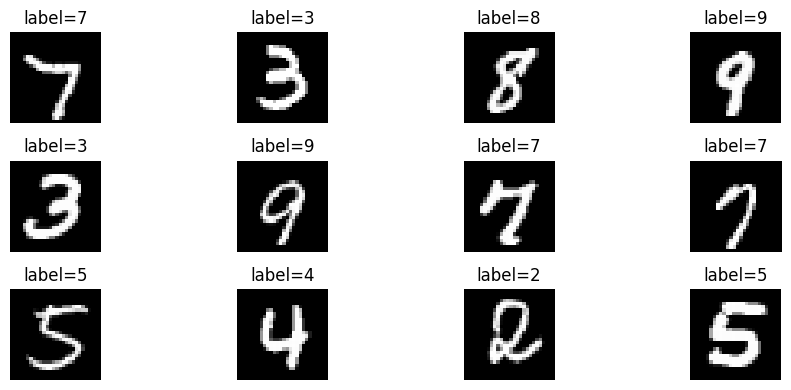

In [ ]:
plt.figure(figsize=(10,4))
indices = np.random.RandomState(SEED).choice(len(x_train), size=12, replace=False)
for i, idx in enumerate(indices):
    plt.subplot(3,4,i+1)
    plt.imshow(x_train[idx], cmap='gray')
    plt.title(f"label={y_train[idx]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### Split the dataset

In [ ]:
from sklearn.model_selection import train_test_split
import numpy
# Combine both sets
X = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

print("Full dataset shape:", X.shape, y.shape)

# Normalize pixel values (0-255 → 0-1)
X = X.astype('float32') / 255.0

# 70% train, 30% temp (val+test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=SEED, stratify=y)

# Split 30% temp → 15% val + 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)

# Check label distribution
unique, counts = np.unique(y_train, return_counts=True)
train_dist = dict(zip(unique, counts))
print("Sample train distribution (first 5):", list(train_dist.items())[:5])


Full dataset shape: (70000, 28, 28) (70000,)
Train: (49000, 28, 28)
Val  : (10500, 28, 28)
Test : (10500, 28, 28)
Sample train distribution (first 5): [(np.uint8(0), np.int64(4832)), (np.uint8(1), np.int64(5514)), (np.uint8(2), np.int64(4893)), (np.uint8(3), np.int64(4999)), (np.uint8(4), np.int64(4777))]


Pre-processing and DataLoader creation

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T

# Convert numpy arrays to torch tensors
X_train_t = torch.tensor(X_train).unsqueeze(1)   # (N,1,28,28)
X_val_t   = torch.tensor(X_val).unsqueeze(1)
X_test_t  = torch.tensor(X_test).unsqueeze(1)
y_train_t = torch.tensor(y_train)
y_val_t   = torch.tensor(y_val)
y_test_t  = torch.tensor(y_test)

print("Torch shapes:", X_train_t.shape, y_train_t.shape)

# Transformations for pretrained models (ImageNet)
imagenet_transforms = T.Compose([
    T.Resize((224,224)),
    T.Grayscale(num_output_channels=3),  # ensure RGB channels (3)
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Since we already have tensors, create helper dataset wrapper
class MNISTDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        image = self.X[idx].numpy()
        image = np.repeat(image, 3, axis=0)  # convert to 3 channels
        image = torch.tensor(image, dtype=torch.float32)
        # Resize & normalize using torchvision if needed
        if self.transform:
            # Convert back to PIL for transform
            import torchvision.transforms.functional as F
            image = F.to_pil_image(image)
            image = self.transform(image)
        label = self.y[idx]
        return image, label

# Create datasets
train_dataset = MNISTDataset(X_train_t, y_train_t, transform=imagenet_transforms)
val_dataset   = MNISTDataset(X_val_t,   y_val_t,   transform=imagenet_transforms)
test_dataset  = MNISTDataset(X_test_t,  y_test_t,  transform=imagenet_transforms)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print("Train batches:", len(train_loader), "Val batches:", len(val_loader), "Test batches:", len(test_loader))


Torch shapes: torch.Size([49000, 1, 28, 28]) torch.Size([49000])
Train batches: 766 Val batches: 165 Test batches: 165


## ResNet-50 model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load pre-trained ResNet50 model
resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Freeze early layers to keep pretrained features (optional)
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (1000 -> 10 classes)
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 10)

resnet = resnet.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.fc.parameters(), lr=1e-4)

# Training loop
def train_model(model, train_loader, val_loader, epochs=5):
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        val_loss = 0.0
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    return train_losses, val_losses

# Train for 5 epochs first
train_losses_resnet, val_losses_resnet = train_model(resnet, train_loader, val_loader, epochs=20)


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Epoch [1/20] | Train Loss: 1.1743 | Val Loss: 0.7007 | Val Acc: 86.69%
Epoch [2/20] | Train Loss: 0.5798 | Val Loss: 0.4786 | Val Acc: 89.24%
Epoch [3/20] | Train Loss: 0.4403 | Val Loss: 0.3958 | Val Acc: 90.58%
Epoch [4/20] | Train Loss: 0.3719 | Val Loss: 0.3418 | Val Acc: 91.41%
Epoch [5/20] | Train Loss: 0.3334 | Val Loss: 0.3133 | Val Acc: 91.70%
Epoch [6/20] | Train Loss: 0.3026 | Val Loss: 0.2879 | Val Acc: 92.13%
Epoch [7/20] | Train Loss: 0.2802 | Val Loss: 0.2677 | Val Acc: 92.69%
Epoch [8/20] | Train Loss: 0.2641 | Val Loss: 0.2528 | Val Acc: 93.00%
Epoch [9/20] | Train Loss: 0.2504 | Val Loss: 0.2409 | Val Acc: 93.18%
Epoch [10/20] | Train Loss: 0.2401 | Val Loss: 0.2332 | Val Acc: 93.52%
Epoch [11/20] | Train Loss: 0.2303 | Val Loss: 0.2246 | Val Acc: 93.67%
Epoch [12/20] | Train Loss: 0.2229 | Val Loss: 0.2179 | Val Acc: 93.76%
Epoch [13/20] | Train Loss: 0.2153 | Val Loss: 0.2139 | Val Acc: 93.93%
Epoch [14/20] | Train Loss: 0.2100 | Val Loss: 0.2068 | Val Acc: 94.20%
E

#### Train and validation loss

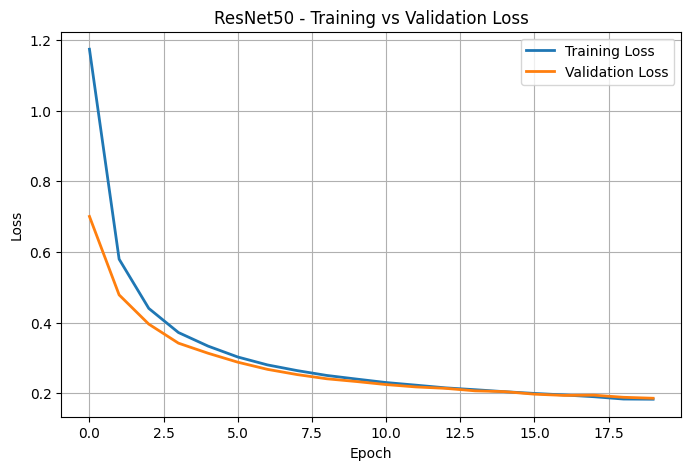

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(8,5))
plt.plot(train_losses_resnet, label='Training Loss', linewidth=2)
plt.plot(val_losses_resnet, label='Validation Loss', linewidth=2)
plt.title("ResNet50 - Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Evaluate ResNet50 on the Test Set

✅ Test Accuracy (ResNet50): 94.71%


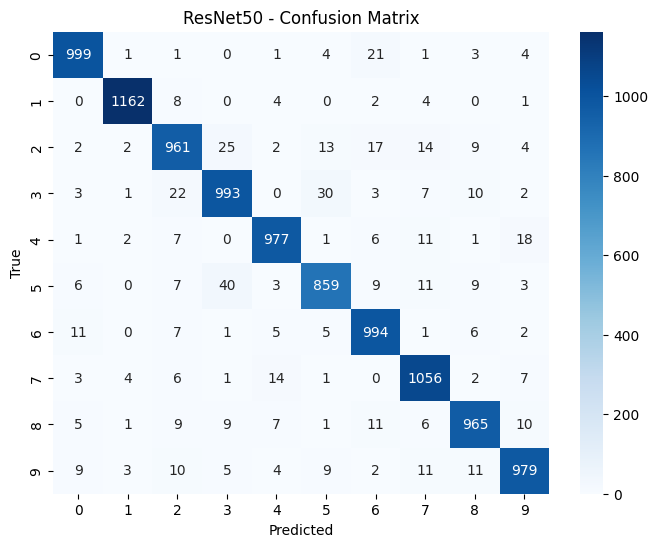


Classification Report (ResNet50):

              precision    recall  f1-score   support

           0     0.9615    0.9652    0.9634      1035
           1     0.9881    0.9839    0.9860      1181
           2     0.9258    0.9161    0.9209      1049
           3     0.9246    0.9272    0.9259      1071
           4     0.9607    0.9541    0.9574      1024
           5     0.9307    0.9071    0.9187       947
           6     0.9333    0.9632    0.9480      1032
           7     0.9412    0.9653    0.9531      1094
           8     0.9498    0.9424    0.9461      1024
           9     0.9505    0.9386    0.9445      1043

    accuracy                         0.9471     10500
   macro avg     0.9466    0.9463    0.9464     10500
weighted avg     0.9472    0.9471    0.9471     10500



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Switch to evaluation mode
resnet.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
accuracy = (all_preds == all_labels).mean() * 100
print(f"✅ Test Accuracy (ResNet50): {accuracy:.2f}%")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("ResNet50 - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print("\nClassification Report (ResNet50):\n")
print(classification_report(all_labels, all_preds, digits=4))


## Train DenseNet-121

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

# ✅ Load pretrained DenseNet121
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# ✅ Freeze all layers initially
for param in densenet_model.parameters():
    param.requires_grad = False

# ✅ Replace the classifier for 10 MNIST classes
num_features = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_features, 10)

# ✅ Move to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet_model = densenet_model.to(device)

# ✅ Define loss function and optimizer (only classifier parameters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet_model.classifier.parameters(), lr=0.001)

# ✅ Train for 20 epochs with validation
num_epochs = 20
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    densenet_model.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    # ---- Training ----
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = densenet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)

    # ---- Validation ----
    densenet_model.eval()
    val_loss = 0.0
    correct_val, total_val = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = densenet_model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = 100 * correct_val / total_val
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

print("\n✅ DenseNet-121 Training Completed.")


Epoch 1/20: 100%|██████████| 766/766 [04:28<00:00,  2.85it/s]


Epoch [1/20] | Train Loss: 0.4633 | Val Loss: 0.2317 | Val Acc: 93.93%


Epoch 2/20: 100%|██████████| 766/766 [04:22<00:00,  2.91it/s]


Epoch [2/20] | Train Loss: 0.2041 | Val Loss: 0.1763 | Val Acc: 94.83%


Epoch 3/20: 100%|██████████| 766/766 [04:25<00:00,  2.88it/s]


Epoch [3/20] | Train Loss: 0.1646 | Val Loss: 0.1463 | Val Acc: 95.51%


Epoch 4/20: 100%|██████████| 766/766 [04:26<00:00,  2.88it/s]


Epoch [4/20] | Train Loss: 0.1430 | Val Loss: 0.1396 | Val Acc: 95.73%


Epoch 5/20: 100%|██████████| 766/766 [04:27<00:00,  2.87it/s]


Epoch [5/20] | Train Loss: 0.1325 | Val Loss: 0.1320 | Val Acc: 95.91%


Epoch 6/20: 100%|██████████| 766/766 [04:25<00:00,  2.88it/s]


Epoch [6/20] | Train Loss: 0.1259 | Val Loss: 0.1261 | Val Acc: 96.02%


Epoch 7/20: 100%|██████████| 766/766 [04:20<00:00,  2.94it/s]


Epoch [7/20] | Train Loss: 0.1197 | Val Loss: 0.1242 | Val Acc: 96.19%


Epoch 8/20: 100%|██████████| 766/766 [04:20<00:00,  2.94it/s]


Epoch [8/20] | Train Loss: 0.1147 | Val Loss: 0.1319 | Val Acc: 95.84%


Epoch 9/20: 100%|██████████| 766/766 [04:27<00:00,  2.86it/s]


Epoch [9/20] | Train Loss: 0.1090 | Val Loss: 0.1215 | Val Acc: 96.01%


Epoch 10/20: 100%|██████████| 766/766 [04:23<00:00,  2.90it/s]


Epoch [10/20] | Train Loss: 0.1076 | Val Loss: 0.1213 | Val Acc: 96.32%


Epoch 11/20: 100%|██████████| 766/766 [04:27<00:00,  2.86it/s]


Epoch [11/20] | Train Loss: 0.1035 | Val Loss: 0.1220 | Val Acc: 96.22%


Epoch 12/20: 100%|██████████| 766/766 [04:24<00:00,  2.89it/s]


Epoch [12/20] | Train Loss: 0.1028 | Val Loss: 0.1226 | Val Acc: 96.04%


Epoch 13/20: 100%|██████████| 766/766 [04:26<00:00,  2.88it/s]


Epoch [13/20] | Train Loss: 0.0979 | Val Loss: 0.1286 | Val Acc: 95.90%


Epoch 14/20: 100%|██████████| 766/766 [04:26<00:00,  2.87it/s]


Epoch [14/20] | Train Loss: 0.0970 | Val Loss: 0.1137 | Val Acc: 96.54%


Epoch 15/20: 100%|██████████| 766/766 [04:24<00:00,  2.90it/s]


Epoch [15/20] | Train Loss: 0.0966 | Val Loss: 0.1189 | Val Acc: 96.33%


Epoch 16/20: 100%|██████████| 766/766 [04:20<00:00,  2.94it/s]


Epoch [16/20] | Train Loss: 0.0952 | Val Loss: 0.1168 | Val Acc: 96.50%


Epoch 17/20: 100%|██████████| 766/766 [04:25<00:00,  2.89it/s]


Epoch [17/20] | Train Loss: 0.0923 | Val Loss: 0.1208 | Val Acc: 96.02%


Epoch 18/20: 100%|██████████| 766/766 [04:26<00:00,  2.88it/s]


Epoch [18/20] | Train Loss: 0.0916 | Val Loss: 0.1208 | Val Acc: 96.35%


Epoch 19/20: 100%|██████████| 766/766 [04:27<00:00,  2.86it/s]


Epoch [19/20] | Train Loss: 0.0889 | Val Loss: 0.1143 | Val Acc: 96.54%


Epoch 20/20: 100%|██████████| 766/766 [04:23<00:00,  2.90it/s]


Epoch [20/20] | Train Loss: 0.0873 | Val Loss: 0.1155 | Val Acc: 96.45%

✅ DenseNet-121 Training Completed.


Train and validation loss

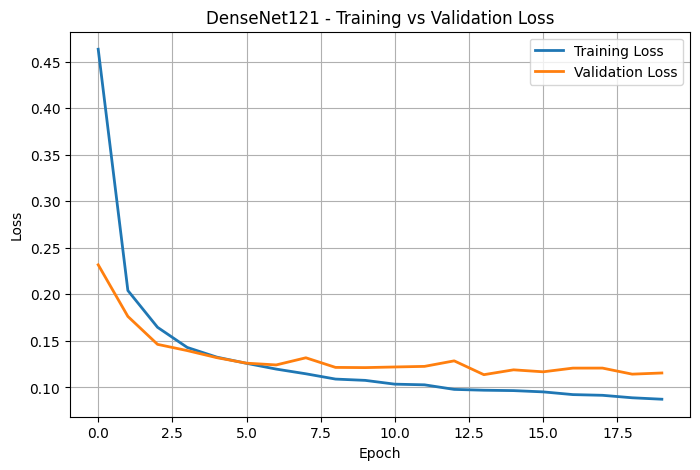

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.title("DenseNet121 - Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Evaluate your DenseNet121 on the test set


 DenseNet121 Test Accuracy: 96.29%

Classification Report:

              precision    recall  f1-score   support

           0     0.9706    0.9894    0.9799      1035
           1     0.9717    0.9890    0.9803      1181
           2     0.9562    0.9361    0.9461      1049
           3     0.9505    0.9496    0.9500      1071
           4     0.9803    0.9717    0.9760      1024
           5     0.9184    0.9504    0.9341       947
           6     0.9793    0.9632    0.9712      1032
           7     0.9625    0.9607    0.9616      1094
           8     0.9705    0.9639    0.9672      1024
           9     0.9659    0.9511    0.9585      1043

    accuracy                         0.9629     10500
   macro avg     0.9626    0.9625    0.9625     10500
weighted avg     0.9630    0.9629    0.9629     10500



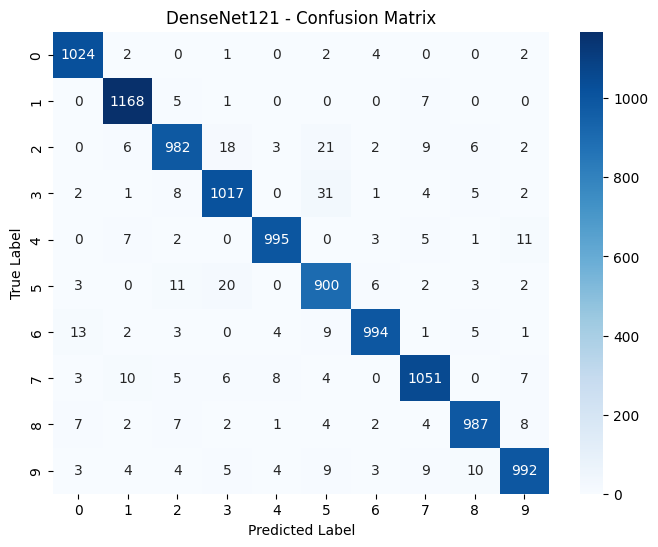

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ---- Set model to evaluation mode ----
densenet_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = densenet_model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# ---- Compute test accuracy ----
test_acc = accuracy_score(y_true, y_pred) * 100
print(f"\n DenseNet121 Test Accuracy: {test_acc:.2f}%\n")

# ---- Classification report ----
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("DenseNet121 - Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
